## 使用torch-directml使用fashion mnist数据集训练CNN

FASHION MNIST则是对Pytorch官方文档中推荐的案例，通过该案例可以快速入门AI训练方法。这里我将把该模型的训练过程记录下来，作为Pytorch的Hello World。

### 1. 环境准备
笔者的设备是一台搭载AMD AI Max+ 395/8060S核显的MINI PC，它的GPU算力大致相当于4060ti。由于它属于AMD的iGPU系列，所以并不支持CUDA生态。为了运行Pytorch代码，需要用到微软开发的torch-directml包。安装它的办法可以参考微软官方给出的说明文档，这里不再赘述。

### 2. 数据准备

#### 2.1 下载训练集

In [2]:
import torch
import torchvision
from torchvision import transforms

trans = transforms.ToTensor()

training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=trans, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=trans, download=True)

print(len(training_set), len(validation_set))
print(len(validation_set[0]))

60000 10000
2


上面代码块的输出结果说明FASHION MNIST的训练集有60,000张图片，验证集有10,000图片。而每个图片用一个二元组表示，第一个元素表示图片的图像数据，第二个元素表示图片的标签。我们可以观察下这个数据长什么样子：

In [3]:
print(validation_set[0][0].shape)
print(type(validation_set[0][1]))

torch.Size([1, 28, 28])
<class 'int'>


#### 2.2 数据集验证
由上面的输出结果，很容易看出图片的格式是28x28的灰阶图片，而标签则是一个int类型的数字。根据这一信息，笔者可以定义函数`show_dataset_items`来验证数据集中的数据是否正确下载：

In [4]:
from matplotlib import pyplot as plt

TEXT_LABELS = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

def get_fashion_mnist_labels(labels):
    return [TEXT_LABELS[int(i)] for i in labels]

def show_dataset_items(imgs, num_rows, num_cols, titles=None, scale=1.5):
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    plt.show()

取数据集的前10项来测试一下`show_dataset_items`的正确性：

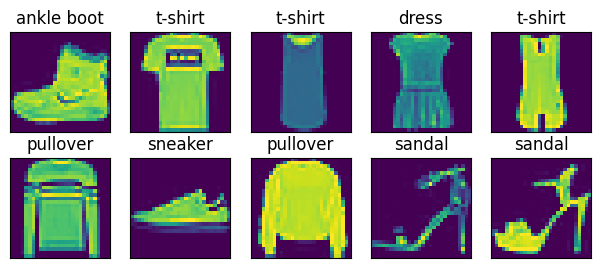

In [5]:
X, y = next(iter(torch.utils.data.DataLoader(training_set, batch_size=10)))
show_dataset_items(X.reshape(10, 28, 28), 2, 5, get_fashion_mnist_labels(y))

如果正确下载数据集，则上面的验证代码将把数据集的前十项的图片跟标签都打印出来。

### 3. 构建模型
由于FASHION MNIST数据集的结构很简单，因此只需要构造简单的CNN模型就可以。模型包含三个卷积层、两个池化层和一个全连接层。

In [6]:
from torch import nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(5, 5), padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        self.fc = nn.Linear(5 * 5 * 64, 10)
    
    def forward(self, x):
        out = self.pool1(self.layer1(x))
        out = self.pool2(self.layer3(self.layer2(out)))
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = CNN()

#### 4. 训练模型

首先定义模型超参数：

In [7]:
import torch_directml

device = torch_directml.device()
model.to(device)
model.train()

print('choose device:', device)

LR = 0.01
EPOCHS = 50
BATCH_SIZE = 256


criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

choose device: privateuseone:0


然后加载数据集：

In [8]:
train_loader = torch.utils.data.DataLoader(training_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(validation_set, batch_size=BATCH_SIZE, shuffle=True)

开始训练：

In [9]:
losses = []

for epoch in range(EPOCHS):
    for i, (images, lables) in enumerate(train_loader):
        images = images.to(device)
        lables = lables.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
        losses.append(loss.cpu().data.item())
        if (i + 1) % 100 == 0:
            print('Epoch : %d/%d, Iter : %d/%d, Loss : %.4f' % (
                epoch + 1, EPOCHS,
                i + 1, len(training_set) // BATCH_SIZE,
                loss.data.item()
            ))

c:\Users\yangy\miniconda3\envs\pytdml\Lib\site-packages\torch\optim\adam.py:534: UserWarning: The operator 'aten::lerp.Scalar_out' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  torch._foreach_lerp_(device_exp_avgs, device_grads, 1 - beta1)


Epoch : 1/50, Iter : 100/234, Loss : 0.5581
Epoch : 1/50, Iter : 200/234, Loss : 0.3027
Epoch : 2/50, Iter : 100/234, Loss : 0.2431
Epoch : 2/50, Iter : 200/234, Loss : 0.3346
Epoch : 3/50, Iter : 100/234, Loss : 0.2795
Epoch : 3/50, Iter : 200/234, Loss : 0.2145
Epoch : 4/50, Iter : 100/234, Loss : 0.2499
Epoch : 4/50, Iter : 200/234, Loss : 0.2155
Epoch : 5/50, Iter : 100/234, Loss : 0.2369
Epoch : 5/50, Iter : 200/234, Loss : 0.2006
Epoch : 6/50, Iter : 100/234, Loss : 0.2366
Epoch : 6/50, Iter : 200/234, Loss : 0.2002
Epoch : 7/50, Iter : 100/234, Loss : 0.2138
Epoch : 7/50, Iter : 200/234, Loss : 0.1652
Epoch : 8/50, Iter : 100/234, Loss : 0.1554
Epoch : 8/50, Iter : 200/234, Loss : 0.1953
Epoch : 9/50, Iter : 100/234, Loss : 0.1693
Epoch : 9/50, Iter : 200/234, Loss : 0.1691
Epoch : 10/50, Iter : 100/234, Loss : 0.1858
Epoch : 10/50, Iter : 200/234, Loss : 0.1423
Epoch : 11/50, Iter : 100/234, Loss : 0.1843
Epoch : 11/50, Iter : 200/234, Loss : 0.1804
Epoch : 12/50, Iter : 100/23

简单绘制一下loss曲线，可以看到训练结果是收敛的：

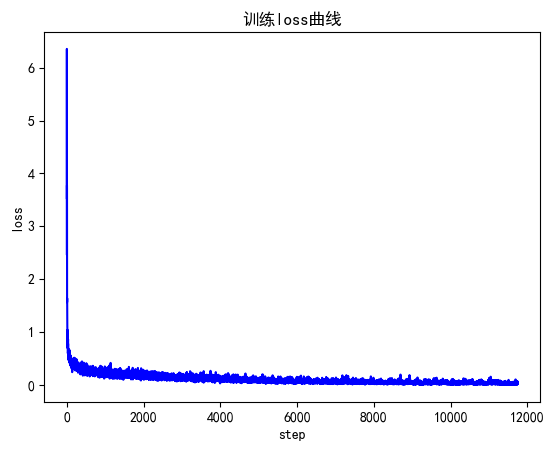

In [10]:
from matplotlib import pyplot as plt

# 设置字体为 SimHei，确保中文显示正常
plt.rcParams['font.sans-serif'] = ['SimHei']  # 或其他中文字体，如 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示为方块的问题

x = range(len(losses))
y = losses

plt.plot(x, y, color='b')
plt.title("训练loss曲线")
plt.xlabel("step")
plt.ylabel("loss")
plt.show()

下面笔者将对模型进行测试：

In [11]:
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float().to(device)
    outputs = model(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('CNN 测试集准确率：%.2f %%' % (100 * correct / total))

CNN 测试集准确率：90.94 %


经过测试，笔者对训练结果满意。接下来就是把训练好的模型保存下来：

In [13]:
torch.save(model.state_dict(), 'model/model_weights.pth')